In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pickle

import pdb
import itertools

In [2]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

In [3]:
from compute_features import compute_features, load_features

In [4]:
db_location = '/users/data/blier/ESC-50/'
log_features = True
log_eps = 0.01
nfolds = 1
split = 0.25
pca_components = 5
pca_time_width = 1
pca_time_stride = 7
pca_freq_width = 15
pca_freq_stride = 7

connections = 'pca_net'

#update this list to test over different features
features = 'mfcc' #, 'plain_scat_1', 'plain_scat_2']

params = {'channels': (84,12), 'hops': (512,4),
          'fmin':32.7, 'fmax':11001,
          'alphas':(6,6),'Qs':(12,12), # only used for flex scattering
          'nclasses': 50, 'n_itemsbyclass':40, 'max_sample_size':2**17,
          'audio_ext':'*.ogg'}

In [5]:
load = True

In [6]:
if load:
    scat_trans = "/users/data/blier/features_esc50/scat/"
    X, y = load_features(scat_trans, params['nclasses'], params['n_itemsbyclass'])
else:
    root_path = "/users/data/blier/ESC-50"
    X, y = compute_features(root_path, features, params)

101 - Dog.pkl
102 - Rooster.pkl
103 - Pig.pkl
104 - Cow.pkl
105 - Frog.pkl
106 - Cat.pkl
107 - Hen.pkl
108 - Insects.pkl
109 - Sheep.pkl
110 - Crow.pkl
201 - Rain.pkl
202 - Sea waves.pkl
203 - Crackling fire.pkl
204 - Crickets.pkl
205 - Chirping birds.pkl
206 - Water drops.pkl
207 - Wind.pkl
208 - Pouring water.pkl
209 - Toilet flush.pkl
210 - Thunderstorm.pkl
301 - Crying baby.pkl
302 - Sneezing.pkl
303 - Clapping.pkl
304 - Breathing.pkl
305 - Coughing.pkl
306 - Footsteps.pkl
307 - Laughing.pkl
308 - Brushing teeth.pkl
309 - Snoring.pkl
310 - Drinking - sipping.pkl
401 - Door knock.pkl
402 - Mouse click.pkl
403 - Keyboard typing.pkl
404 - Door - wood creaks.pkl
405 - Can opening.pkl
406 - Washing machine.pkl
407 - Vacuum cleaner.pkl
408 - Clock alarm.pkl
409 - Clock tick.pkl
410 - Glass breaking.pkl
501 - Helicopter.pkl
502 - Chainsaw.pkl
503 - Siren.pkl
504 - Car horn.pkl
505 - Engine.pkl
506 - Train.pkl
507 - Church bells.pkl
508 - Airplane.pkl
509 - Fireworks.pkl
510 - Hand saw.pkl

In [7]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, 
                     random_state=42, stratify=y)

In [8]:
len(X_test)

500

In [9]:
class Concat_scat_tree():
    def __init__(self, M=1, transf=None, log=True):
        self.M = M
        self.transf = transf
        self.log = log
    
    def fit(self, X, y=None, *args):
        return self
    
    def transform(self, X, *args, **kwargs):
        if self.log:
            fun = lambda x: np.log(np.abs(x))
        else:
            fun = np.abs
            
        if self.transf == "max":
            fun1 = lambda x: fun(x).max(axis=-1)
        elif self.transf == "mean":
            fun1 = lambda x: fun(x).mean(axis=-1)
        else:
            fun1 = fun
        
        X_transformed = np.stack([np.concatenate(
                    [fun1(x[i]).ravel() for i in range(self.M)]
                ) for x in X ])
        
        #X_transformed = np.log(X_transformed)
        print("shape", X_transformed.shape)
        return X_transformed
    
class Concat_scal():
    def __init__(self, transf=None, log=True):
        self.transf = transf
    
    def fit(self, X, y=None, *args):
        return self
    
    def transform(self, X, *args, **kwargs):
        X_transformed = np.stack(X, axis=0)
        if self.transf == "max":
            X_transformed = np.max(X_transformed, axis=-1)
        elif self.transf == "mean":
            X_transformed = np.mean(X_transformed, axis=-1)
            
        X_transformed = X_transformed.reshape((X_transformed.shape[0],-1))
        #X_transformed = np.log(X_transformed)
        print("shape", X_transformed.shape)
        return X_transformed

In [10]:
classifier1 = SVC(C=1., kernel='linear')
classifier2 = RandomForestClassifier()
estimators = [('concat', Concat_scat_tree(M = 3, transf='mean')), ('classifier', classifier1)]

#estimators = [('concat', Concat_scal(transf='max')),('svc', SVC(C=1., kernel='linear'))]
pipe = Pipeline(estimators)

In [11]:
pipe.fit(X_train, y_train)

shape (1500, 661)


Pipeline(steps=[('concat', <__main__.Concat_scat_tree object at 0x7fb69f759ba8>), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [12]:
score_train = pipe.score(X_train, y_train)
score_test = pipe.score(X_test, y_test)
score_train, score_test

shape (1500, 661)
shape (500, 661)


(0.99533333333333329, 0.40200000000000002)

In [13]:
y_pred = pipe.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

shape (500, 661)


In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #    plt.text(j, i, cm[i, j],
    #             horizontalalignment="center",
    #             color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix
[[ 0.5  0.   0.  ...,  0.   0.   0. ]
 [ 0.1  0.5  0.  ...,  0.   0.   0. ]
 [ 0.   0.   0.4 ...,  0.   0.   0. ]
 ..., 
 [ 0.   0.   0.1 ...,  0.4  0.   0. ]
 [ 0.   0.   0.1 ...,  0.   0.4  0. ]
 [ 0.   0.   0.1 ...,  0.1  0.   0.1]]


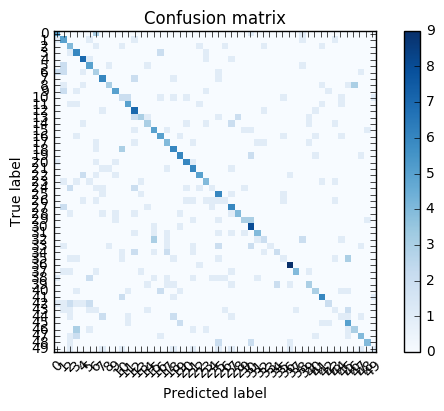

In [15]:
plot_confusion_matrix(conf, range(params["nclasses"]), normalize=True)

In [16]:
conc = Concat(M=1)
values = conc.transform(X).ravel()

NameError: name 'Concat' is not defined

In [ ]:
from scipy import histogram

In [ ]:
y, x = histogram(conc.transform(X[:40]).ravel(), bins=100)
plt.plot(x[:100], y[:100])

In [ ]:
sum([x[0].dtype != np.complex64 for x in X])

## 